# Holography Simulator

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from skimage.restoration import unwrap_phase

from libertem.utils.generate import hologram_frame
from libertem.io.dataset.memory import MemoryDataSet
from libertem.udf.holography import HoloReconstructUDF
from libertem.api import Context

import hyperspy.api as hs

In [3]:
# Setup context
ctx = Context()

Generate amplitude and phase images.

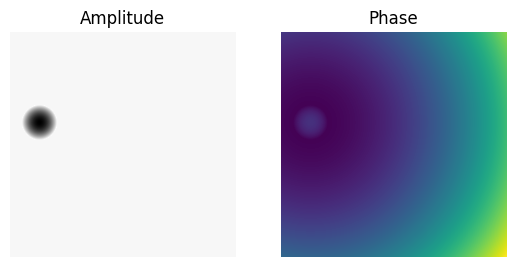

In [4]:
# Define grid
sx, sy = (256, 256)
mx, my = np.meshgrid(np.arange(sx), np.arange(sy))
# Define sphere region
sphere = (mx - 33.)**2 + (my - 103.)**2 < 20.**2
# Calculate long-range contribution to the phase
phase = ((mx - 33.)**2 + (my - 103.)**2) / sx / 40.
# Add mean inner potential contribution to the phase
phase[sphere] += (-((mx[sphere] - 33.)**2 \
                   + (my[sphere] - 103.)**2) / sx / 3 + 0.5) * 2.
# Calculate amplitude of the phase
amp = np.ones_like(phase)
amp[sphere] = ((mx[sphere] - 33.)**2 \
               + (my[sphere] - 103.)**2) / sx / 3 + 0.5

# Plot
f, ax = plt.subplots(1, 2)
ax[0].imshow(amp, cmap='gray')
ax[0].title.set_text('Amplitude')
ax[0].set_axis_off()
ax[1].imshow(phase, cmap='viridis')
ax[1].title.set_text('Phase')
ax[1].set_axis_off()

Compute holograms

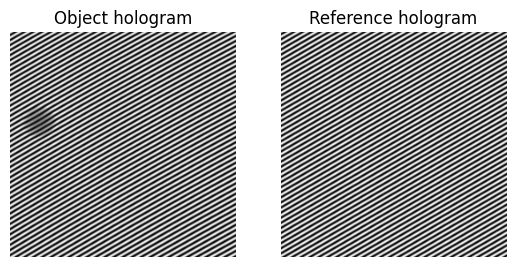

In [5]:
holo = hologram_frame(amp, phase)
ref = hologram_frame(np.ones_like(phase), np.zeros_like(phase))

# Plot
f, ax = plt.subplots(1, 2)
ax[0].imshow(holo, cmap='gray')
ax[0].title.set_text('Object hologram')
ax[0].set_axis_off()
ax[1].imshow(ref, cmap='gray')
ax[1].title.set_text('Reference hologram')
ax[1].set_axis_off()

Compute reconstruction

In [6]:
dataset_holo = MemoryDataSet(data=holo.reshape((1, sx, sy)), tileshape=(1, sx, sy), num_partitions=1, sig_dims=2)
dataset_ref = MemoryDataSet(data=ref.reshape((1, sx, sy)), tileshape=(1, sx, sy), num_partitions=1, sig_dims=2)

Text(0.5, 1.0, 'FFT of the reference hologram')

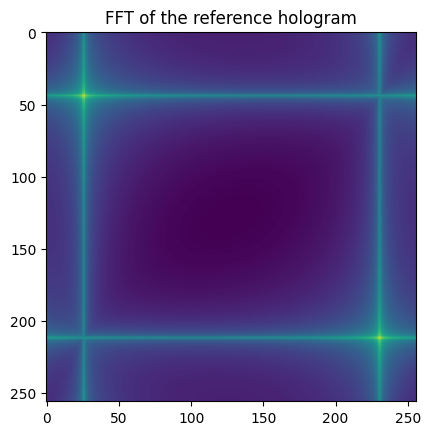

In [21]:
plt.imshow(np.log(np.abs(np.fft.fft2(ref))))
plt.title('FFT of the reference hologram')

In [ ]:
plt.imshow(holo, cmap='gray')

Text(0.5, 1.0, 'FFT of the reference hologram')

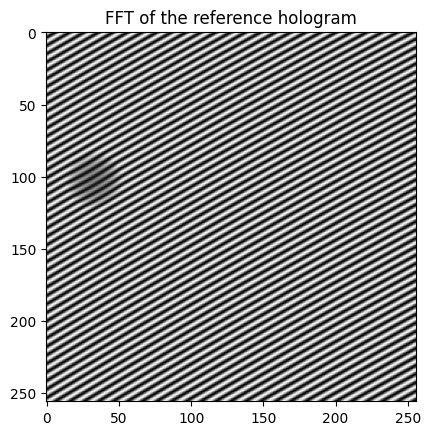

In [ ]:
plt.imshow(np.abs(np.fft.ifft2(np.fft.fft2(holo))), cmap='gray')
plt.title('FFT of the reference hologram')

In [22]:
# Store the hologram in a Singal2D to estimate the sideband position and size
holo_signal2d = hs.signals.Signal2D(ref)
holo_signal2d.set_signal_type("hologram")

sb_position = holo_signal2d.estimate_sideband_position(ap_cb_radius=None, sb='lower')
sb_size = holo_signal2d.estimate_sideband_size(sb_position)

sb_position = sb_position.data
sb_size = sb_size.data[0]

print(sb_position)
print(sb_size)

[44 26]
25.553864678361276


In [18]:
# Define output shape
output_shape = (int(sb_size * 2), int(sb_size * 2))

# Create reconstruction UDF:
holo_udf = HoloReconstructUDF(out_shape=output_shape,
                              sb_position=sb_position,
                              sb_size=sb_size)

# Reconstruct holograms, access data directly
w_holo = ctx.run_udf(dataset=dataset_holo, udf=holo_udf)['wave'].data
w_ref = ctx.run_udf(dataset=dataset_ref, udf=holo_udf)['wave'].data

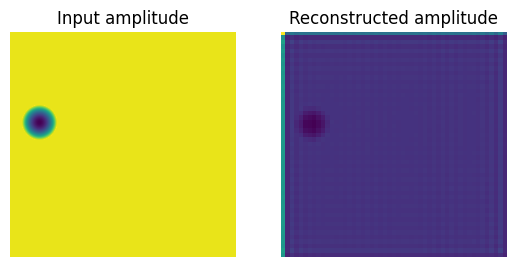

In [19]:
# Correct object wave using reference wave
w = w_holo / w_ref

# Calculate plot phase shift and amplitude
amp_r = np.abs(w)
phase_r = np.angle(w)

# Plot amplitude
f, ax = plt.subplots(1, 2)
ax[0].imshow(amp)
ax[0].title.set_text('Input amplitude')
ax[0].set_axis_off()
ax[1].imshow(amp_r[0])
ax[1].title.set_text('Reconstructed amplitude')
ax[1].set_axis_off()

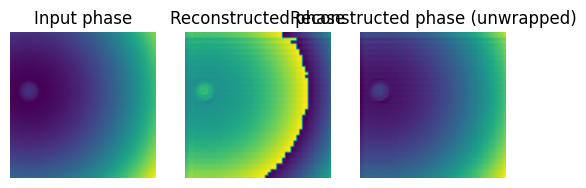

In [35]:
# Unwrap phase:
phase_unwrapped = unwrap_phase(phase_r[0])

# Plot
f, ax = plt.subplots(1, 3)
ax[0].imshow(phase, cmap='viridis')
ax[0].title.set_text('Input phase')
ax[0].set_axis_off()
ax[1].imshow(phase_r[0])
ax[1].title.set_text('Reconstructed phase')
ax[1].set_axis_off()
ax[2].imshow(phase_unwrapped, cmap='viridis')
ax[2].title.set_text('Reconstructed phase (unwrapped)')
ax[2].set_axis_off()

In [1]:
ctx.close()

NameError: name 'ctx' is not defined